# COVID-19 Vaccinations by County

## Data Understanding

A full explanation of the different column names can be found [here](https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-County/8xkx-amqh/about_data). Below, we include some of the more important labels.

* [MMWR Week](https://ndc.services.cdc.gov/wp-content/uploads/MMWR_Week_overview.pdf), under `MMWR_week`, refers to the epidemiological ordering of weeks of the year, starting on Sunday and going until Saturday. These weeks are generally numbered 1-52.
* `Completeness_pct` corresponds to "the proportion of people with a completed primary series whose Federal Information Processing Standards (FIPS) code is reported and matches a valid county FIPS code in the jurisdiction."
    * Someone has completed their **primary series** if they have received a "second dose of a two-dose vaccine or one dose of a single-dose vaccine."
* There are then a number of different age brackets: the total number and percentage of individuals vaccinated who are above the ages of 5, 12, 18, and 64. So, for example, we have `Administered_Dose1_Recip`; the percentage form of that, `Administered_Dose1_Pop_Pct`; the raw numbers of those over 5 years old, `Administered_Dose1_Recip_5Plus`, and so on.
* `Booster_Doses` indicates the number of individuals who have completed a primary series and received a booster dose.

* `SVI` refers to the [social vulnerability index](https://www.atsdr.cdc.gov/placeandhealth/svi/index.html).
* `Metro_status` tells us whether someone lives within a metro area. We have a number of columns normalizing our data against both SVI and metro status.
* `Census2019` and associated columns bring over data from the 2019 census.
* We also have data about those receiving the bivalent booster (authorized by the FDA [late summer 2022](https://www.fda.gov/news-events/press-announcements/coronavirus-covid-19-update-fda-authorizes-moderna-pfizer-biontech-bivalent-covid-19-vaccines-use)), although this data only appears in age-binned categories.


---

Other useful information and links
* [FIPS codes](https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html#ti1187912100)

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

census_race = pd.read_csv('../data/cc-est2022-all.csv', encoding="latin-1")
census_age = pd.read_csv('../data/cc-est2022-agesex-all.csv')
deaths = pd.read_csv('../data/Provisional_COVID-19_Deaths_by_County__and_Race_and_Hispanic_Origin_20240102.csv')
vaccinations = pd.read_csv('../data/COVID-19_Vaccinations_by_County.csv')
election = pd.read_csv('../data/2020_US_County_Level_Presidential_Results.csv')

education = pd.read_excel('../data/Education.xlsx')
poverty = pd.read_excel('../data/PovertyEstimates.xlsx')

/Users/shelleywang/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [97]:
vaccinations.groupby(by="Recip_State")["Recip_County"].value_counts()

# Note the "Unknown County"

Recip_State  Recip_County              
AK           Aleutians East Borough        598
             Aleutians West Census Area    598
             Anchorage Municipality        598
             Bethel Census Area            598
             Bristol Bay Borough           598
                                          ... 
WY           Teton County                  598
             Uinta County                  598
             Washakie County               598
             Weston County                 598
             Unknown County                595
Name: Recip_County, Length: 3284, dtype: int64

In [98]:
vaccinations["Recip_State"].value_counts().__len__()

60

In [99]:
vaccinations["Recip_State"].value_counts()


TX     152177
GA      95677
VA      80130
KY      72356
MO      69365
KS      63385
IL      61592
NC      60396
IA      59797
TN      57405
NE      56209
IN      55611
OH      53219
MN      52622
MI      50230
MS      49631
PR      47238
OK      46641
AR      45445
WI      43652
PA      40662
FL      40661
AL      40660
SD      40064
CO      38867
LA      38867
NY      37672
CA      35279
MT      34083
WV      33484
ND      32290
SC      28104
ID      26907
WA      23917
OR      22122
NM      20329
UT      17937
AK      17936
MD      14947
WY      14349
NJ      13153
NV      10761
ME      10163
AZ       9565
VT       8968
MA       8967
NH       6575
CT       5379
RI       3585
HI       3264
DE       2389
VI       2382
DC       1192
GU       1191
FM        594
MP        591
AS        589
PW        588
MH        581
UNK       308
Name: Recip_State, dtype: int64

In [100]:
# Removing PR (Puerto Rico), GU (Guam), and VI (Virgin Islands)
vaccinations = vaccinations[(vaccinations["Recip_State"] != "PR") & (vaccinations["Recip_State"] != "GU") & (vaccinations["Recip_State"] != "VI")]
vaccinations["Recip_State"].value_counts().__len__()

57

In [101]:
def drop_terrs(df, state):
    df = df[(df[state] != "PR") & (df[state] != "GU") & (df[state] != "VI") & (df[state] != "AK")]
    return df


def County_with_State(df, county, state):
    df["County_with_State"] = df[county] + ", " + df[state]

In [102]:
# Removing unknown counties
vaccinations = vaccinations[vaccinations["Recip_County"] != "Unknown County"]

County_with_State(vaccinations, "Recip_County", "Recip_State")
vaccinations["County_with_State"].value_counts()

# Leaves us with 3142 unique counties, each with 598 entries.

Warren County, VA      598
Wayne County, GA       598
Cook County, MN        598
Mitchell County, GA    598
Oconee County, SC      598
                      ... 
Hudson County, NJ      598
Floyd County, TX       598
Lawrence County, OH    598
Sierra County, CA      598
McMinn County, TN      598
Name: County_with_State, Length: 3142, dtype: int64

In [103]:
vaccinations

,Date,FIPS,MMWR_week,Recip_County,Recip_State,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_5PlusPop_Pct,...,Census2019_65PlusPop,Bivalent_Booster_5Plus,Bivalent_Booster_5Plus_Pop_Pct,Bivalent_Booster_12Plus,Bivalent_Booster_12Plus_Pop_Pct,Bivalent_Booster_18Plus,Bivalent_Booster_18Plus_Pop_Pct,Bivalent_Booster_65Plus,Bivalent_Booster_65Plus_Pop_Pct,County_with_State
0,05/10/2023,55129,19,Washburn County,WI,96.7,11123.0,70.8,11097.0,73.9,...,4304.0,3978.0,26.5,3955.0,28.6,3899.0,30.6,2588.0,60.1,"Washburn County, WI"
1,05/10/2023,19173,19,Taylor County,IA,97.3,3149.0,51.4,3145.0,55.0,...,1392.0,841.0,14.7,841.0,16.3,834.0,17.8,588.0,42.2,"Taylor County, IA"
2,05/10/2023,36059,19,Nassau County,NY,97.5,1391226.0,95.0,1384503.0,95.0,...,246690.0,236202.0,18.4,231748.0,19.8,224931.0,21.1,109947.0,44.6,"Nassau County, NY"
3,05/10/2023,48281,19,Lampasas County,TX,98.9,11678.0,54.5,11660.0,57.4,...,4322.0,1951.0,9.6,1947.0,10.5,1925.0,11.5,1229.0,28.4,"Lampasas County, TX"
4,05/10/2023,26145,19,Saginaw County,MI,94.0,104075.0,54.6,NaN,NaN,...,37414.0,15618.0,8.7,15448.0,9.4,15112.0,10.1,7921.0,21.2,"Saginaw County, MI"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962776,12/13/2020,39001,51,Adams County,OH,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Adams County, OH"
1962777,12/13/2020,18061,51,Harrison County,IN,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Harrison County, IN"
1962778,12/13/2020,48321,51,Matagorda County,TX,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Matagorda County, TX"
1962779,12/13/2020,54073,51,Pleasants County,WV,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Pleasants County, WV"


In [104]:
# Only using year-end dates for 2021 and 2022, and most recent available data for 2023.
# 05/10/2023; 12/28/2022; 12/31/2021

vaccinations = vaccinations[(vaccinations["Date"] == "05/10/2023")]
vaccinations
# And we're left with 3113 rows, corresponding to 1 entry per county.

,Date,FIPS,MMWR_week,Recip_County,Recip_State,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_5PlusPop_Pct,...,Census2019_65PlusPop,Bivalent_Booster_5Plus,Bivalent_Booster_5Plus_Pop_Pct,Bivalent_Booster_12Plus,Bivalent_Booster_12Plus_Pop_Pct,Bivalent_Booster_18Plus,Bivalent_Booster_18Plus_Pop_Pct,Bivalent_Booster_65Plus,Bivalent_Booster_65Plus_Pop_Pct,County_with_State
0,05/10/2023,55129,19,Washburn County,WI,96.7,11123.0,70.8,11097.0,73.9,...,4304.0,3978.0,26.5,3955.0,28.6,3899.0,30.6,2588.0,60.1,"Washburn County, WI"
1,05/10/2023,19173,19,Taylor County,IA,97.3,3149.0,51.4,3145.0,55.0,...,1392.0,841.0,14.7,841.0,16.3,834.0,17.8,588.0,42.2,"Taylor County, IA"
2,05/10/2023,36059,19,Nassau County,NY,97.5,1391226.0,95.0,1384503.0,95.0,...,246690.0,236202.0,18.4,231748.0,19.8,224931.0,21.1,109947.0,44.6,"Nassau County, NY"
3,05/10/2023,48281,19,Lampasas County,TX,98.9,11678.0,54.5,11660.0,57.4,...,4322.0,1951.0,9.6,1947.0,10.5,1925.0,11.5,1229.0,28.4,"Lampasas County, TX"
4,05/10/2023,26145,19,Saginaw County,MI,94.0,104075.0,54.6,NaN,NaN,...,37414.0,15618.0,8.7,15448.0,9.4,15112.0,10.1,7921.0,21.2,"Saginaw County, MI"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3278,05/10/2023,29153,19,Ozark County,MO,91.3,3762.0,41.0,3760.0,42.9,...,2684.0,732.0,8.4,730.0,9.0,724.0,9.8,512.0,19.1,"Ozark County, MO"
3279,05/10/2023,46065,19,Hughes County,SD,96.7,16373.0,93.4,16308.0,95.0,...,3158.0,3659.0,22.4,3601.0,24.7,3499.0,26.3,1857.0,58.8,"Hughes County, SD"
3280,05/10/2023,26027,19,Cass County,MI,94.0,26815.0,51.8,NaN,NaN,...,11149.0,3330.0,6.8,3293.0,7.3,3219.0,7.8,1822.0,16.3,"Cass County, MI"
3281,05/10/2023,32001,19,Churchill County,NV,95.1,16252.0,65.2,16164.0,69.5,...,4759.0,2576.0,11.1,2544.0,12.1,2475.0,12.9,1439.0,30.2,"Churchill County, NV"


In [105]:
# fig, ax = plt.subplots(figsize=(10, 5))
# ax = saginaw_mi.plot(x="Date", y="Series_Complete_Pop_Pct", ax=ax)

## Presidential Election Data

In [106]:
election.head()

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff
0,Alabama,1001,Autauga County,19838,7503,27770,12335,0.714368,0.270184,0.444184
1,Alabama,1003,Baldwin County,83544,24578,109679,58966,0.761714,0.224090,0.537623
2,Alabama,1005,Barbour County,5622,4816,10518,806,0.534512,0.457882,0.076631
3,Alabama,1007,Bibb County,7525,1986,9595,5539,0.784263,0.206983,0.577280
4,Alabama,1009,Blount County,24711,2640,27588,22071,0.895716,0.095694,0.800022


In [107]:
# adding a state_abbrev column
state_abbrevs = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

election["state_abbrev"] = election["state_name"].map(state_abbrevs)
election.head()

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff,state_abbrev
0,Alabama,1001,Autauga County,19838,7503,27770,12335,0.714368,0.270184,0.444184,AL
1,Alabama,1003,Baldwin County,83544,24578,109679,58966,0.761714,0.224090,0.537623,AL
2,Alabama,1005,Barbour County,5622,4816,10518,806,0.534512,0.457882,0.076631,AL
3,Alabama,1007,Bibb County,7525,1986,9595,5539,0.784263,0.206983,0.577280,AL
4,Alabama,1009,Blount County,24711,2640,27588,22071,0.895716,0.095694,0.800022,AL


In [108]:
election["state_name"].value_counts().__len__()

51

In [109]:
election.groupby(by="state_abbrev")["county_name"].value_counts()

state_abbrev  county_name      
AK            District 1           1
              District 10          1
              District 11          1
              District 12          1
              District 13          1
                                  ..
WY            Sweetwater County    1
              Teton County         1
              Uinta County         1
              Washakie County      1
              Weston County        1
Name: county_name, Length: 3152, dtype: int64

In [110]:
election

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff,state_abbrev
0,Alabama,1001,Autauga County,19838,7503,27770,12335,0.714368,0.270184,0.444184,AL
1,Alabama,1003,Baldwin County,83544,24578,109679,58966,0.761714,0.224090,0.537623,AL
2,Alabama,1005,Barbour County,5622,4816,10518,806,0.534512,0.457882,0.076631,AL
3,Alabama,1007,Bibb County,7525,1986,9595,5539,0.784263,0.206983,0.577280,AL
4,Alabama,1009,Blount County,24711,2640,27588,22071,0.895716,0.095694,0.800022,AL
...,...,...,...,...,...,...,...,...,...,...,...
3147,Wyoming,56037,Sweetwater County,12229,3823,16603,8406,0.736554,0.230260,0.506294,WY
3148,Wyoming,56039,Teton County,4341,9848,14677,-5507,0.295769,0.670982,-0.375213,WY
3149,Wyoming,56041,Uinta County,7496,1591,9402,5905,0.797277,0.169219,0.628058,WY
3150,Wyoming,56043,Washakie County,3245,651,4012,2594,0.808824,0.162263,0.646560,WY


In [111]:
election["votes_third_party"] = election["total_votes"] - election["votes_dem"] - election["votes_gop"]
election["per_third_party"] = round(100 * election["votes_third_party"] / election["total_votes"], 1)


In [112]:
election['per_gop'] = round(100 * election['per_gop'], 1)
election['per_dem'] = round(100 * election['per_dem'], 1)

In [113]:
# Dropping PR (Puerto Rico), GU (Guam), and VI (Virgin Islands)
# This doesn't actually change the total number of counties.
election = election[(election["state_abbrev"] != "PR") & (election["state_abbrev"] != "GU") & (election["state_abbrev"] != "VI")]
election.groupby(by="state_abbrev")["county_name"].value_counts()


state_abbrev  county_name      
AK            District 1           1
              District 10          1
              District 11          1
              District 12          1
              District 13          1
                                  ..
WY            Sweetwater County    1
              Teton County         1
              Uinta County         1
              Washakie County      1
              Weston County        1
Name: county_name, Length: 3152, dtype: int64

In [114]:
County_with_State(election, "county_name", "state_abbrev")
election["County_with_State"].value_counts()

Jack County, TX            1
Carson County, TX          1
Chase County, NE           1
Kimball County, NE         1
Hillsborough County, NH    1
                          ..
Copiah County, MS          1
Yadkin County, NC          1
Bucks County, PA           1
Greene County, AL          1
Rio Grande County, CO      1
Name: County_with_State, Length: 3152, dtype: int64

In [115]:
# Function to automatically compare difference in counties:
def check_overlap(df1, df2, column):
    vc1 = pd.DataFrame(df1[column])
    vc2 = pd.DataFrame(df2[column])
    combined = pd.merge(vc1, vc2, how="outer", indicator=True)
    combined_right = combined[combined["_merge"] == "right_only"]
    combined_left = combined[combined["_merge"] == "left_only"]
    return combined_right.value_counts(), combined_left.value_counts()

check_overlap(election, vaccinations, "County_with_State")

(County_with_State                      _merge    
 Yukon-Koyukuk Census Area, AK          right_only    1
 Yakutat City and Borough, AK           right_only    1
 Aleutians West Census Area, AK         right_only    1
 Anchorage Municipality, AK             right_only    1
 Bethel Census Area, AK                 right_only    1
 Bristol Bay Borough, AK                right_only    1
 Denali Borough, AK                     right_only    1
 Dillingham Census Area, AK             right_only    1
 Dona Ana County, NM                    right_only    1
 Fairbanks North Star Borough, AK       right_only    1
 Haines Borough, AK                     right_only    1
 Hoonah-Angoon Census Area, AK          right_only    1
 Juneau City and Borough, AK            right_only    1
 Kalawao County, HI                     right_only    1
 Kenai Peninsula Borough, AK            right_only    1
 Ketchikan Gateway Borough, AK          right_only    1
 Kodiak Island Borough, AK              right_only   

"Unlike other states within the United States, Alaska does not administer its presidential elections at the county-level but rather at the lower chamber legislative district, or the House District."[link](https://github.com/tonmcg/US_County_Level_Election_Results_08-20?tab=readme-ov-file#alaska)

In [116]:
# Removing Alaska from the dfs:
election = election[election["state_abbrev"] != "AK"]
vaccinations = vaccinations[vaccinations["Recip_State"] != "AK"]

# Comparing again:
check_overlap(election, vaccinations, "County_with_State")

(County_with_State    _merge    
 La Salle Parish, LA  right_only    1
 Kalawao County, HI   right_only    1
 Dona Ana County, NM  right_only    1
 dtype: int64,
 County_with_State    _merge   
 LaSalle Parish, LA   left_only    1
 Doña Ana County, NM  left_only    1
 dtype: int64)

In [117]:
# Renaming the different county names to match
election["County_with_State"] = election["County_with_State"].replace("Doña Ana County, NM", "Dona Ana County, NM")
election["county_name"] = election["county_name"].replace("Doña Ana County", "Dona Ana County")
election["County_with_State"] = election["County_with_State"].replace("LaSalle Parish, LA", "La Salle Parish, LA")
election["county_name"] = election["county_name"].replace("LaSalle Parish", "La Salle Parish")

# Comparing again:
check_overlap(election, vaccinations, "County_with_State")



(County_with_State   _merge    
 Kalawao County, HI  right_only    1
 dtype: int64,
 Series([], dtype: int64))

# Paring down and combining Election + Vaccination Dataframes

In [118]:
election

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff,state_abbrev,votes_third_party,per_third_party,County_with_State
0,Alabama,1001,Autauga County,19838,7503,27770,12335,71.4,27.0,0.444184,AL,429,1.5,"Autauga County, AL"
1,Alabama,1003,Baldwin County,83544,24578,109679,58966,76.2,22.4,0.537623,AL,1557,1.4,"Baldwin County, AL"
2,Alabama,1005,Barbour County,5622,4816,10518,806,53.5,45.8,0.076631,AL,80,0.8,"Barbour County, AL"
3,Alabama,1007,Bibb County,7525,1986,9595,5539,78.4,20.7,0.577280,AL,84,0.9,"Bibb County, AL"
4,Alabama,1009,Blount County,24711,2640,27588,22071,89.6,9.6,0.800022,AL,237,0.9,"Blount County, AL"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147,Wyoming,56037,Sweetwater County,12229,3823,16603,8406,73.7,23.0,0.506294,WY,551,3.3,"Sweetwater County, WY"
3148,Wyoming,56039,Teton County,4341,9848,14677,-5507,29.6,67.1,-0.375213,WY,488,3.3,"Teton County, WY"
3149,Wyoming,56041,Uinta County,7496,1591,9402,5905,79.7,16.9,0.628058,WY,315,3.4,"Uinta County, WY"
3150,Wyoming,56043,Washakie County,3245,651,4012,2594,80.9,16.2,0.646560,WY,116,2.9,"Washakie County, WY"


In [119]:
election = election[["per_gop", "per_dem", "per_third_party", "County_with_State"]]
election

,per_gop,per_dem,per_third_party,County_with_State
0,71.4,27.0,1.5,"Autauga County, AL"
1,76.2,22.4,1.4,"Baldwin County, AL"
2,53.5,45.8,0.8,"Barbour County, AL"
3,78.4,20.7,0.9,"Bibb County, AL"
4,89.6,9.6,0.9,"Blount County, AL"
...,...,...,...,...
3147,73.7,23.0,3.3,"Sweetwater County, WY"
3148,29.6,67.1,3.3,"Teton County, WY"
3149,79.7,16.9,3.4,"Uinta County, WY"
3150,80.9,16.2,2.9,"Washakie County, WY"


In [120]:
vaccinations

,Date,FIPS,MMWR_week,Recip_County,Recip_State,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_5PlusPop_Pct,...,Census2019_65PlusPop,Bivalent_Booster_5Plus,Bivalent_Booster_5Plus_Pop_Pct,Bivalent_Booster_12Plus,Bivalent_Booster_12Plus_Pop_Pct,Bivalent_Booster_18Plus,Bivalent_Booster_18Plus_Pop_Pct,Bivalent_Booster_65Plus,Bivalent_Booster_65Plus_Pop_Pct,County_with_State
0,05/10/2023,55129,19,Washburn County,WI,96.7,11123.0,70.8,11097.0,73.9,...,4304.0,3978.0,26.5,3955.0,28.6,3899.0,30.6,2588.0,60.1,"Washburn County, WI"
1,05/10/2023,19173,19,Taylor County,IA,97.3,3149.0,51.4,3145.0,55.0,...,1392.0,841.0,14.7,841.0,16.3,834.0,17.8,588.0,42.2,"Taylor County, IA"
2,05/10/2023,36059,19,Nassau County,NY,97.5,1391226.0,95.0,1384503.0,95.0,...,246690.0,236202.0,18.4,231748.0,19.8,224931.0,21.1,109947.0,44.6,"Nassau County, NY"
3,05/10/2023,48281,19,Lampasas County,TX,98.9,11678.0,54.5,11660.0,57.4,...,4322.0,1951.0,9.6,1947.0,10.5,1925.0,11.5,1229.0,28.4,"Lampasas County, TX"
4,05/10/2023,26145,19,Saginaw County,MI,94.0,104075.0,54.6,NaN,NaN,...,37414.0,15618.0,8.7,15448.0,9.4,15112.0,10.1,7921.0,21.2,"Saginaw County, MI"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3278,05/10/2023,29153,19,Ozark County,MO,91.3,3762.0,41.0,3760.0,42.9,...,2684.0,732.0,8.4,730.0,9.0,724.0,9.8,512.0,19.1,"Ozark County, MO"
3279,05/10/2023,46065,19,Hughes County,SD,96.7,16373.0,93.4,16308.0,95.0,...,3158.0,3659.0,22.4,3601.0,24.7,3499.0,26.3,1857.0,58.8,"Hughes County, SD"
3280,05/10/2023,26027,19,Cass County,MI,94.0,26815.0,51.8,NaN,NaN,...,11149.0,3330.0,6.8,3293.0,7.3,3219.0,7.8,1822.0,16.3,"Cass County, MI"
3281,05/10/2023,32001,19,Churchill County,NV,95.1,16252.0,65.2,16164.0,69.5,...,4759.0,2576.0,11.1,2544.0,12.1,2475.0,12.9,1439.0,30.2,"Churchill County, NV"


In [121]:
"""
Filter by 
* Date
* County_with_State
* Series_Complete_Pop_Pct
* Metro_status
"""

vaccinations = vaccinations[["Date", "County_with_State", "Series_Complete_Pop_Pct", "Metro_status"]]
vaccinations

,Date,County_with_State,Series_Complete_Pop_Pct,Metro_status
0,05/10/2023,"Washburn County, WI",65.7,Non-metro
1,05/10/2023,"Taylor County, IA",48.2,Non-metro
2,05/10/2023,"Nassau County, NY",86.9,Metro
3,05/10/2023,"Lampasas County, TX",46.7,Metro
4,05/10/2023,"Saginaw County, MI",54.1,Metro
...,...,...,...,...
3278,05/10/2023,"Ozark County, MO",33.3,Non-metro
3279,05/10/2023,"Hughes County, SD",76.8,Non-metro
3280,05/10/2023,"Cass County, MI",45.7,Metro
3281,05/10/2023,"Churchill County, NV",56.3,Non-metro


In [122]:
# Making the combined df

df = pd.merge(election, vaccinations, how="inner", on="County_with_State")
df

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status
0,71.4,27.0,1.5,"Autauga County, AL",05/10/2023,46.1,Metro
1,76.2,22.4,1.4,"Baldwin County, AL",05/10/2023,53.4,Metro
2,53.5,45.8,0.8,"Barbour County, AL",05/10/2023,47.4,Non-metro
3,78.4,20.7,0.9,"Bibb County, AL",05/10/2023,36.5,Metro
4,89.6,9.6,0.9,"Blount County, AL",05/10/2023,32.9,Metro
...,...,...,...,...,...,...,...
3107,73.7,23.0,3.3,"Sweetwater County, WY",05/10/2023,52.9,Non-metro
3108,29.6,67.1,3.3,"Teton County, WY",05/10/2023,95.0,Non-metro
3109,79.7,16.9,3.4,"Uinta County, WY",05/10/2023,54.0,Non-metro
3110,80.9,16.2,2.9,"Washakie County, WY",05/10/2023,45.2,Non-metro


In [123]:
df['County_with_State'].value_counts()

Jack County, TX          1
Emanuel County, GA       1
Linn County, MO          1
Calhoun County, MI       1
Carson County, TX        1
                        ..
Clinton County, KY       1
Warren County, IN        1
Clallam County, WA       1
Broome County, NY        1
Rio Grande County, CO    1
Name: County_with_State, Length: 3112, dtype: int64

# Poverty dataset

In [124]:
poverty = pd.read_excel('../data/PovertyEstimates.xlsx')

poverty.columns = poverty.iloc[3]
poverty

3,FIPS_Code,Stabr,Area_name,Rural-urban_Continuum_Code_2003,Urban_Influence_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_ 2013,POVALL_2021,CI90LBALL_2021,CI90UBALL_2021,...,CI90UB517P_2021,MEDHHINC_2021,CI90LBINC_2021,CI90UBINC_2021,POV04_2021,CI90LB04_2021,CI90UB04_2021,PCTPOV04_2021,CI90LB04P_2021,CI90UB04P_2021
0,"Source: U.S. Department of Commerce, Bureau of...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"For definitions of rural classifications, see ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"This table was prepared by USDA, Economic Rese...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FIPS_Code,Stabr,Area_name,Rural-urban_Continuum_Code_2003,Urban_Influence_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_ 2013,POVALL_2021,CI90LBALL_2021,CI90UBALL_2021,...,CI90UB517P_2021,MEDHHINC_2021,CI90LBINC_2021,CI90UBINC_2021,POV04_2021,CI90LB04_2021,CI90UB04_2021,PCTPOV04_2021,CI90LB04P_2021,CI90UB04P_2021
4,00000,US,United States,NaN,NaN,NaN,NaN,41393176,41149497,41636855,...,16.3,69717,69583,69851,3349149,3299669,3398629,18.3,18,18.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3194,56037,WY,Sweetwater County,5,8,5,8,3761,3048,4474,...,11.5,74677,66928,82426,NaN,NaN,NaN,NaN,NaN,NaN
3195,56039,WY,Teton County,7,8,7,8,1392,1070,1714,...,6.4,102709,90132,115286,NaN,NaN,NaN,NaN,NaN,NaN
3196,56041,WY,Uinta County,7,8,7,8,1917,1457,2377,...,12.9,70162,62206,78118,NaN,NaN,NaN,NaN,NaN,NaN
3197,56043,WY,Washakie County,7,11,7,11,773,579,967,...,15.6,62176,55415,68937,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
poverty.drop(poverty.index[0:5], inplace=True)
poverty = drop_terrs(poverty, "Stabr")
# poverty = poverty[(poverty["Stabr"] != "PR") & (poverty["Stabr"] != "GU") & (poverty["Stabr"] != "VI") & (poverty["Stabr"] != "AK")]
poverty

3,FIPS_Code,Stabr,Area_name,Rural-urban_Continuum_Code_2003,Urban_Influence_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_ 2013,POVALL_2021,CI90LBALL_2021,CI90UBALL_2021,...,CI90UB517P_2021,MEDHHINC_2021,CI90LBINC_2021,CI90UBINC_2021,POV04_2021,CI90LB04_2021,CI90UB04_2021,PCTPOV04_2021,CI90LB04P_2021,CI90UB04P_2021
5,01000,AL,Alabama,NaN,NaN,NaN,NaN,800848,782169,819527,...,22.5,53990,53218,54762,71220,66888,75552,25.1,23.6,26.6
6,01001,AL,Autauga County,2,2,2,2,6296,4772,7820,...,20.4,66444,60061,72827,NaN,NaN,NaN,NaN,NaN,NaN
7,01003,AL,Baldwin County,4,5,3,2,25526,21599,29453,...,18.5,65658,60723,70593,NaN,NaN,NaN,NaN,NaN,NaN
8,01005,AL,Barbour County,6,6,6,6,5089,3773,6405,...,44.6,38649,34308,42990,NaN,NaN,NaN,NaN,NaN,NaN
9,01007,AL,Bibb County,1,1,1,1,4204,3324,5084,...,35.4,48454,42438,54470,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3194,56037,WY,Sweetwater County,5,8,5,8,3761,3048,4474,...,11.5,74677,66928,82426,NaN,NaN,NaN,NaN,NaN,NaN
3195,56039,WY,Teton County,7,8,7,8,1392,1070,1714,...,6.4,102709,90132,115286,NaN,NaN,NaN,NaN,NaN,NaN
3196,56041,WY,Uinta County,7,8,7,8,1917,1457,2377,...,12.9,70162,62206,78118,NaN,NaN,NaN,NaN,NaN,NaN
3197,56043,WY,Washakie County,7,11,7,11,773,579,967,...,15.6,62176,55415,68937,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
County_with_State(poverty, "Area_name", "Stabr")
poverty.head()

<ipython-input-101-3c6bf79f3f30>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["County_with_State"] = df[county] + ", " + df[state]


3,FIPS_Code,Stabr,Area_name,Rural-urban_Continuum_Code_2003,Urban_Influence_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_ 2013,POVALL_2021,CI90LBALL_2021,CI90UBALL_2021,...,MEDHHINC_2021,CI90LBINC_2021,CI90UBINC_2021,POV04_2021,CI90LB04_2021,CI90UB04_2021,PCTPOV04_2021,CI90LB04P_2021,CI90UB04P_2021,County_with_State
5,01000,AL,Alabama,NaN,NaN,NaN,NaN,800848,782169,819527,...,53990,53218,54762,71220,66888,75552,25.1,23.6,26.6,"Alabama, AL"
6,01001,AL,Autauga County,2,2,2,2,6296,4772,7820,...,66444,60061,72827,NaN,NaN,NaN,NaN,NaN,NaN,"Autauga County, AL"
7,01003,AL,Baldwin County,4,5,3,2,25526,21599,29453,...,65658,60723,70593,NaN,NaN,NaN,NaN,NaN,NaN,"Baldwin County, AL"
8,01005,AL,Barbour County,6,6,6,6,5089,3773,6405,...,38649,34308,42990,NaN,NaN,NaN,NaN,NaN,NaN,"Barbour County, AL"
9,01007,AL,Bibb County,1,1,1,1,4204,3324,5084,...,48454,42438,54470,NaN,NaN,NaN,NaN,NaN,NaN,"Bibb County, AL"


In [127]:
check_overlap(df, poverty, "County_with_State")

(County_with_State    _merge    
 Wyoming, WY          right_only    1
 Wisconsin, WI        right_only    1
 Massachusetts, MA    right_only    1
 Maryland, MD         right_only    1
 Maine, ME            right_only    1
 Louisiana, LA        right_only    1
 Lagrange County, IN  right_only    1
 La Salle County, IL  right_only    1
 La Porte County, IN  right_only    1
 Kentucky, KY         right_only    1
 Kansas, KS           right_only    1
 Kalawao County, HI   right_only    1
 Iowa, IA             right_only    1
 Indiana, IN          right_only    1
 Illinois, IL         right_only    1
 Idaho, ID            right_only    1
 Hawaii, HI           right_only    1
 Georgia, GA          right_only    1
 Florida, FL          right_only    1
 Delaware, DE         right_only    1
 DeBaca County, NM    right_only    1
 De Kalb County, IN   right_only    1
 Connecticut, CT      right_only    1
 Colorado, CO         right_only    1
 California, CA       right_only    1
 Arkansas, AR    

In [128]:
state_names = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]
poverty.drop(poverty.index[poverty["Area_name"].isin(state_names)], inplace=True)
poverty

/Users/shelleywang/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


3,FIPS_Code,Stabr,Area_name,Rural-urban_Continuum_Code_2003,Urban_Influence_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_ 2013,POVALL_2021,CI90LBALL_2021,CI90UBALL_2021,...,MEDHHINC_2021,CI90LBINC_2021,CI90UBINC_2021,POV04_2021,CI90LB04_2021,CI90UB04_2021,PCTPOV04_2021,CI90LB04P_2021,CI90UB04P_2021,County_with_State
6,01001,AL,Autauga County,2,2,2,2,6296,4772,7820,...,66444,60061,72827,NaN,NaN,NaN,NaN,NaN,NaN,"Autauga County, AL"
7,01003,AL,Baldwin County,4,5,3,2,25526,21599,29453,...,65658,60723,70593,NaN,NaN,NaN,NaN,NaN,NaN,"Baldwin County, AL"
8,01005,AL,Barbour County,6,6,6,6,5089,3773,6405,...,38649,34308,42990,NaN,NaN,NaN,NaN,NaN,NaN,"Barbour County, AL"
9,01007,AL,Bibb County,1,1,1,1,4204,3324,5084,...,48454,42438,54470,NaN,NaN,NaN,NaN,NaN,NaN,"Bibb County, AL"
10,01009,AL,Blount County,1,1,1,1,6992,5516,8468,...,56894,52632,61156,NaN,NaN,NaN,NaN,NaN,NaN,"Blount County, AL"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3194,56037,WY,Sweetwater County,5,8,5,8,3761,3048,4474,...,74677,66928,82426,NaN,NaN,NaN,NaN,NaN,NaN,"Sweetwater County, WY"
3195,56039,WY,Teton County,7,8,7,8,1392,1070,1714,...,102709,90132,115286,NaN,NaN,NaN,NaN,NaN,NaN,"Teton County, WY"
3196,56041,WY,Uinta County,7,8,7,8,1917,1457,2377,...,70162,62206,78118,NaN,NaN,NaN,NaN,NaN,NaN,"Uinta County, WY"
3197,56043,WY,Washakie County,7,11,7,11,773,579,967,...,62176,55415,68937,NaN,NaN,NaN,NaN,NaN,NaN,"Washakie County, WY"


In [129]:
"""
From poverty dataset, include:
* PCTPOVALL_2021, the overall percentage of people in poverty in 2021
* MEDHHINC_2021, the "[e]stimate of median household income 2021"
* County_with_State
"""

poverty = poverty[["PCTPOVALL_2021", "MEDHHINC_2021", "County_with_State"]]
poverty


3,PCTPOVALL_2021,MEDHHINC_2021,County_with_State
6,10.7,66444,"Autauga County, AL"
7,10.8,65658,"Baldwin County, AL"
8,23,38649,"Barbour County, AL"
9,20.6,48454,"Bibb County, AL"
10,12,56894,"Blount County, AL"
...,...,...,...
3194,9.2,74677,"Sweetwater County, WY"
3195,5.9,102709,"Teton County, WY"
3196,9.4,70162,"Uinta County, WY"
3197,10.2,62176,"Washakie County, WY"


In [130]:
check_overlap(df, poverty, "County_with_State")

(County_with_State    _merge    
 Mc Kean County, PA   right_only    1
 Lagrange County, IN  right_only    1
 La Salle County, IL  right_only    1
 La Porte County, IN  right_only    1
 Kalawao County, HI   right_only    1
 DeBaca County, NM    right_only    1
 De Kalb County, IN   right_only    1
 dtype: int64,
 County_with_State    _merge   
 McKean County, PA    left_only    1
 LaSalle County, IL   left_only    1
 LaPorte County, IN   left_only    1
 LaGrange County, IN  left_only    1
 DeKalb County, IN    left_only    1
 De Baca County, NM   left_only    1
 dtype: int64)

In [131]:
poverty["County_with_State"] = poverty["County_with_State"].replace("De Kalb County, IN", "DeKalb County, IN")
poverty["County_with_State"] = poverty["County_with_State"].replace("DeBaca County, NM", "De Baca County, NM")
poverty["County_with_State"] = poverty["County_with_State"].replace("La Porte County, IN", "LaPorte County, IN")
poverty["County_with_State"] = poverty["County_with_State"].replace("La Salle County, IL", "LaSalle County, IL")
poverty["County_with_State"] = poverty["County_with_State"].replace("Lagrange County, IN", "LaGrange County, IN")
poverty["County_with_State"] = poverty["County_with_State"].replace("Mc Kean County, PA", "McKean County, PA")

check_overlap(df, poverty, "County_with_State")

<ipython-input-131-ce0be59dcc0b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poverty["County_with_State"] = poverty["County_with_State"].replace("De Kalb County, IN", "DeKalb County, IN")
<ipython-input-131-ce0be59dcc0b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poverty["County_with_State"] = poverty["County_with_State"].replace("DeBaca County, NM", "De Baca County, NM")
<ipython-input-131-ce0be59dcc0b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

(County_with_State   _merge    
 Kalawao County, HI  right_only    1
 dtype: int64,
 Series([], dtype: int64))

In [132]:
poverty["County_with_State"].value_counts()

District of Columbia, DC    2
Jack County, TX             1
Fairfield County, SC        1
Carson County, TX           1
Craven County, NC           1
                           ..
Clallam County, WA          1
Broome County, NY           1
Washington County, OK       1
Oxford County, ME           1
Rio Grande County, CO       1
Name: County_with_State, Length: 3113, dtype: int64

In [133]:
poverty.drop_duplicates(subset="County_with_State", inplace=True)
poverty

<ipython-input-133-85d8b882428c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poverty.drop_duplicates(subset="County_with_State", inplace=True)


3,PCTPOVALL_2021,MEDHHINC_2021,County_with_State
6,10.7,66444,"Autauga County, AL"
7,10.8,65658,"Baldwin County, AL"
8,23,38649,"Barbour County, AL"
9,20.6,48454,"Bibb County, AL"
10,12,56894,"Blount County, AL"
...,...,...,...
3194,9.2,74677,"Sweetwater County, WY"
3195,5.9,102709,"Teton County, WY"
3196,9.4,70162,"Uinta County, WY"
3197,10.2,62176,"Washakie County, WY"


In [134]:
poverty["County_with_State"].value_counts()

Jack County, TX          1
Carter County, KY        1
Calhoun County, MI       1
Carson County, TX        1
Craven County, NC        1
                        ..
Clallam County, WA       1
Broome County, NY        1
Washington County, OK    1
Oxford County, ME        1
Rio Grande County, CO    1
Name: County_with_State, Length: 3113, dtype: int64

In [135]:
df = pd.merge(df, poverty, how="inner", on="County_with_State")

In [136]:
df

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021
0,71.4,27.0,1.5,"Autauga County, AL",05/10/2023,46.1,Metro,10.7,66444
1,76.2,22.4,1.4,"Baldwin County, AL",05/10/2023,53.4,Metro,10.8,65658
2,53.5,45.8,0.8,"Barbour County, AL",05/10/2023,47.4,Non-metro,23,38649
3,78.4,20.7,0.9,"Bibb County, AL",05/10/2023,36.5,Metro,20.6,48454
4,89.6,9.6,0.9,"Blount County, AL",05/10/2023,32.9,Metro,12,56894
...,...,...,...,...,...,...,...,...,...
3107,73.7,23.0,3.3,"Sweetwater County, WY",05/10/2023,52.9,Non-metro,9.2,74677
3108,29.6,67.1,3.3,"Teton County, WY",05/10/2023,95.0,Non-metro,5.9,102709
3109,79.7,16.9,3.4,"Uinta County, WY",05/10/2023,54.0,Non-metro,9.4,70162
3110,80.9,16.2,2.9,"Washakie County, WY",05/10/2023,45.2,Non-metro,10.2,62176


In [137]:
df[df["County_with_State"].str.endswith("CT")]["County_with_State"].value_counts()


New Haven County, CT     1
Hartford County, CT      1
Windham County, CT       1
Fairfield County, CT     1
New London County, CT    1
Tolland County, CT       1
Litchfield County, CT    1
Middlesex County, CT     1
Name: County_with_State, dtype: int64

# Deaths!

In [138]:
deaths = pd.read_csv('../data/Provisional_COVID-19_Deaths_by_County__and_Race_and_Hispanic_Origin_20240102.csv')
deaths

,Data as of,Start Date,End Date,State,County Name,Urban Rural Code,FIPS State,FIPS County,FIPS Code,Indicator,...,COVID-19 Deaths,Non-Hispanic White,Non-Hispanic Black,Non-Hispanic American Indian or Alaska Native,Non-Hispanic Asian,Non-Hispanic Native Hawaiian or Other Pacific Islander,Hispanic,Other,Urban Rural Description,Footnote
0,09/27/2023,01/01/2020,09/23/2023,AK,Anchorage Municipality,3,2,20,2020,Distribution of all-cause deaths (%),...,787,0.568,0.044,0.216,0.058,0.030,0.033,0.050,Medium metro,NaN
1,09/27/2023,01/01/2020,09/23/2023,AK,Anchorage Municipality,3,2,20,2020,Distribution of COVID-19 deaths (%),...,787,0.452,0.037,0.255,0.111,0.074,0.038,0.033,Medium metro,NaN
2,09/27/2023,01/01/2020,09/23/2023,AK,Anchorage Municipality,3,2,20,2020,Distribution of population (%),...,787,0.564,0.052,0.083,0.098,0.031,0.095,0.077,Medium metro,NaN
3,09/27/2023,01/01/2020,09/23/2023,AK,Fairbanks North Star Borough,4,2,90,2090,Distribution of all-cause deaths (%),...,214,0.710,0.024,0.173,0.020,NaN,0.027,0.044,Small metro,One or more data cells have counts between 1-9...
4,09/27/2023,01/01/2020,09/23/2023,AK,Fairbanks North Star Borough,4,2,90,2090,Distribution of COVID-19 deaths (%),...,214,0.626,NaN,0.257,NaN,NaN,NaN,0.056,Small metro,One or more data cells have counts between 1-9...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3682,09/27/2023,01/01/2020,09/23/2023,WY,Sheridan County,5,56,33,56033,Distribution of COVID-19 deaths (%),...,101,0.861,NaN,NaN,NaN,NaN,NaN,NaN,Micropolitan,One or more data cells have counts between 1-9...
3683,09/27/2023,01/01/2020,09/23/2023,WY,Sheridan County,5,56,33,56033,Distribution of population (%),...,101,0.913,0.007,0.011,0.008,0.001,0.047,0.014,Micropolitan,NaN
3684,09/27/2023,01/01/2020,09/23/2023,WY,Sweetwater County,5,56,37,56037,Distribution of all-cause deaths (%),...,115,0.885,0.013,0.009,NaN,NaN,0.083,NaN,Micropolitan,One or more data cells have counts between 1-9...
3685,09/27/2023,01/01/2020,09/23/2023,WY,Sweetwater County,5,56,37,56037,Distribution of COVID-19 deaths (%),...,115,0.887,NaN,NaN,NaN,NaN,0.096,NaN,Micropolitan,One or more data cells have counts between 1-9...


In [139]:
3687/3

1229.0

In [140]:
deaths["County Name"].value_counts()

Jefferson County     42
Washington County    39
Jackson County       30
Montgomery County    30
Marion County        27
                     ..
Van Buren County      3
Grenada County        3
Laclede County        3
Simpson County        3
Alexandria city       3
Name: County Name, Length: 901, dtype: int64

In [141]:
deaths["Indicator"].value_counts()

Distribution of all-cause deaths (%)    1229
Distribution of population (%)          1229
Distribution of COVID-19 deaths (%)     1229
Name: Indicator, dtype: int64

In [142]:
County_with_State(deaths, "County Name", "State")
deaths.head()

,Data as of,Start Date,End Date,State,County Name,Urban Rural Code,FIPS State,FIPS County,FIPS Code,Indicator,...,Non-Hispanic White,Non-Hispanic Black,Non-Hispanic American Indian or Alaska Native,Non-Hispanic Asian,Non-Hispanic Native Hawaiian or Other Pacific Islander,Hispanic,Other,Urban Rural Description,Footnote,County_with_State
0,09/27/2023,01/01/2020,09/23/2023,AK,Anchorage Municipality,3,2,20,2020,Distribution of all-cause deaths (%),...,0.568,0.044,0.216,0.058,0.030,0.033,0.050,Medium metro,NaN,"Anchorage Municipality, AK"
1,09/27/2023,01/01/2020,09/23/2023,AK,Anchorage Municipality,3,2,20,2020,Distribution of COVID-19 deaths (%),...,0.452,0.037,0.255,0.111,0.074,0.038,0.033,Medium metro,NaN,"Anchorage Municipality, AK"
2,09/27/2023,01/01/2020,09/23/2023,AK,Anchorage Municipality,3,2,20,2020,Distribution of population (%),...,0.564,0.052,0.083,0.098,0.031,0.095,0.077,Medium metro,NaN,"Anchorage Municipality, AK"
3,09/27/2023,01/01/2020,09/23/2023,AK,Fairbanks North Star Borough,4,2,90,2090,Distribution of all-cause deaths (%),...,0.710,0.024,0.173,0.020,NaN,0.027,0.044,Small metro,One or more data cells have counts between 1-9...,"Fairbanks North Star Borough, AK"
4,09/27/2023,01/01/2020,09/23/2023,AK,Fairbanks North Star Borough,4,2,90,2090,Distribution of COVID-19 deaths (%),...,0.626,NaN,0.257,NaN,NaN,NaN,0.056,Small metro,One or more data cells have counts between 1-9...,"Fairbanks North Star Borough, AK"


In [143]:
deaths = deaths[deaths["Indicator"] == "Distribution of COVID-19 deaths (%)"]
deaths

,Data as of,Start Date,End Date,State,County Name,Urban Rural Code,FIPS State,FIPS County,FIPS Code,Indicator,...,Non-Hispanic White,Non-Hispanic Black,Non-Hispanic American Indian or Alaska Native,Non-Hispanic Asian,Non-Hispanic Native Hawaiian or Other Pacific Islander,Hispanic,Other,Urban Rural Description,Footnote,County_with_State
1,09/27/2023,01/01/2020,09/23/2023,AK,Anchorage Municipality,3,2,20,2020,Distribution of COVID-19 deaths (%),...,0.452,0.037,0.255,0.111,0.074,0.038,0.033,Medium metro,NaN,"Anchorage Municipality, AK"
4,09/27/2023,01/01/2020,09/23/2023,AK,Fairbanks North Star Borough,4,2,90,2090,Distribution of COVID-19 deaths (%),...,0.626,NaN,0.257,NaN,NaN,NaN,0.056,Small metro,One or more data cells have counts between 1-9...,"Fairbanks North Star Borough, AK"
7,09/27/2023,01/01/2020,09/23/2023,AK,Matanuska-Susitna Borough,3,2,170,2170,Distribution of COVID-19 deaths (%),...,0.826,NaN,0.083,NaN,NaN,0.046,NaN,Medium metro,One or more data cells have counts between 1-9...,"Matanuska-Susitna Borough, AK"
10,09/27/2023,01/01/2020,09/23/2023,AL,Autauga County,3,1,1,1001,Distribution of COVID-19 deaths (%),...,0.761,0.218,NaN,NaN,NaN,NaN,NaN,Medium metro,One or more data cells have counts between 1-9...,"Autauga County, AL"
13,09/27/2023,01/01/2020,09/23/2023,AL,Baldwin County,4,1,3,1003,Distribution of COVID-19 deaths (%),...,0.884,0.086,NaN,NaN,NaN,0.023,NaN,Small metro,One or more data cells have counts between 1-9...,"Baldwin County, AL"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3673,09/27/2023,01/01/2020,09/23/2023,WY,Laramie County,4,56,21,56021,Distribution of COVID-19 deaths (%),...,0.776,NaN,NaN,NaN,NaN,0.170,NaN,Small metro,One or more data cells have counts between 1-9...,"Laramie County, WY"
3676,09/27/2023,01/01/2020,09/23/2023,WY,Natrona County,4,56,25,56025,Distribution of COVID-19 deaths (%),...,0.824,NaN,0.088,NaN,NaN,0.069,NaN,Small metro,One or more data cells have counts between 1-9...,"Natrona County, WY"
3679,09/27/2023,01/01/2020,09/23/2023,WY,Park County,6,56,29,56029,Distribution of COVID-19 deaths (%),...,0.926,NaN,NaN,NaN,NaN,NaN,NaN,Noncore,One or more data cells have counts between 1-9...,"Park County, WY"
3682,09/27/2023,01/01/2020,09/23/2023,WY,Sheridan County,5,56,33,56033,Distribution of COVID-19 deaths (%),...,0.861,NaN,NaN,NaN,NaN,NaN,NaN,Micropolitan,One or more data cells have counts between 1-9...,"Sheridan County, WY"


In [144]:
check_overlap(df, deaths, "County_with_State")

(County_with_State                 _merge    
 Matanuska-Susitna Borough, AK     right_only    1
 La Salle County, IL               right_only    1
 Fairbanks North Star Borough, AK  right_only    1
 Anchorage Municipality, AK        right_only    1
 dtype: int64,
 County_with_State          _merge   
 Ziebach County, SD         left_only    1
 Gosper County, NE          left_only    1
 Gladwin County, MI         left_only    1
 Glascock County, GA        left_only    1
 Glasscock County, TX       left_only    1
                                        ..
 Northampton County, NC     left_only    1
 Northampton County, VA     left_only    1
 Northumberland County, VA  left_only    1
 Norton County, KS          left_only    1
 Abbeville County, SC       left_only    1
 Length: 1887, dtype: int64)

# Census & race

In [145]:
census_race = pd.read_csv('../data/cc-est2022-all.csv', encoding="latin-1")
census_race["state_abbrev"] = census_race["STNAME"].map(state_abbrevs)
County_with_State(census_race, "CTYNAME", "state_abbrev")
census_race

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,state_abbrev,County_with_State
0,50,1,1,Alabama,Autauga County,1,0,58802,28761,30041,...,112,97,40,30,22,24,19,11,AL,"Autauga County, AL"
1,50,1,1,Alabama,Autauga County,1,1,3443,1790,1653,...,14,9,3,1,9,1,3,1,AL,"Autauga County, AL"
2,50,1,1,Alabama,Autauga County,1,2,3613,1849,1764,...,5,8,7,3,0,1,1,2,AL,"Autauga County, AL"
3,50,1,1,Alabama,Autauga County,1,3,4131,2121,2010,...,10,10,1,3,2,2,2,1,AL,"Autauga County, AL"
4,50,1,1,Alabama,Autauga County,1,4,3963,2003,1960,...,8,9,5,2,2,4,3,2,AL,"Autauga County, AL"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238939,50,56,45,Wyoming,Weston County,4,14,590,323,267,...,0,1,0,0,0,0,0,0,WY,"Weston County, WY"
238940,50,56,45,Wyoming,Weston County,4,15,415,231,184,...,0,0,0,0,0,0,0,0,WY,"Weston County, WY"
238941,50,56,45,Wyoming,Weston County,4,16,254,127,127,...,0,0,0,0,0,0,0,0,WY,"Weston County, WY"
238942,50,56,45,Wyoming,Weston County,4,17,141,71,70,...,0,0,1,0,0,0,0,0,WY,"Weston County, WY"


In [146]:
# Removing Alaska and other territories
census_race = drop_terrs(census_race, "state_abbrev")

# Also dropping CT because they changed from counties to different administrative districts
census_race = census_race[census_race["state_abbrev"] != "CT"]

Note: because CT stopped using counties in the census in 2022, we are going to use other data.
[wiki link](https://en.wikipedia.org/wiki/List_of_counties_in_Connecticut)

In [147]:
# Including all age groups
census_race = census_race[census_race["AGEGRP"] == 0]
# Using year 2022
census_race = census_race[census_race["YEAR"] == 4]

In [148]:
census_race["County_with_State"].value_counts()

Jack County, TX               1
Prince George's County, MD    1
Childress County, TX          1
Sevier County, AR             1
Calhoun County, MI            1
                             ..
Bucks County, PA              1
Greene County, AL             1
Clinton County, KY            1
Warren County, IN             1
Rio Grande County, CO         1
Name: County_with_State, Length: 3105, dtype: int64

In [149]:
census_race["WA"] = round(100 * (census_race["WA_MALE"] + census_race["WA_FEMALE"])/census_race["TOT_POP"], 1)
census_race["BA"] = round(100 * (census_race["BA_MALE"] + census_race["BA_FEMALE"])/census_race["TOT_POP"], 1)
census_race["IA"] = round(100 * (census_race["IA_MALE"] + census_race["IA_FEMALE"])/census_race["TOT_POP"], 1)
census_race["AAPI"] = round(100 * (census_race["AA_MALE"] + census_race["NA_MALE"] +  census_race["AA_FEMALE"] + census_race["NA_FEMALE"])/census_race["TOT_POP"], 1)
census_race.head()

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,state_abbrev,County_with_State,WA,BA,IA,AAPI
57,50,1,1,Alabama,Autauga County,4,0,59759,29105,30654,...,23,22,22,19,AL,"Autauga County, AL",74.8,21.4,0.5,1.3
133,50,1,3,Alabama,Baldwin County,4,0,246435,120164,126271,...,118,132,88,86,AL,"Baldwin County, AL",87.4,8.4,0.8,1.2
209,50,1,5,Alabama,Barbour County,4,0,24706,13064,11642,...,10,9,33,18,AL,"Barbour County, AL",49.2,47.7,0.7,0.7
285,50,1,7,Alabama,Bibb County,4,0,22005,11775,10230,...,8,10,19,6,AL,"Bibb County, AL",76.5,21.0,0.6,0.4
361,50,1,9,Alabama,Blount County,4,0,59512,29583,29929,...,15,29,37,28,AL,"Blount County, AL",95.4,1.9,0.6,0.6


In [151]:
# link: https://portal.ct.gov/DPH/Health-Information-Systems--Reporting/Population/Annual-State-County-Population-with-Demographics-for-2000-2019
# https://docs.google.com/spreadsheets/d/1ah9hCG5YFZtguc8Xabcix1ppcR4MWhNh2fq3cyWJ18I/edit?usp=sharing
# dw about this lol
census_race = census_race[["WA", "BA", "IA", "AAPI", "County_with_State"]]
census_race.loc[238869] = [79.5, 13.7, 0.6, 6.2, "Fairfield County, CT"]
census_race.loc[238870] = [76.2, 16.7, 0.7, 6.4, "Hartford County, CT"]
census_race.loc[238871] = [94.3, 2.8, 0.4, 2.4, "Litchfield County, CT"]
census_race.loc[238872] = [89.8, 6.2, 0.3, 3.6, "Middlesex County, CT"]
census_race.loc[238873] = [78.5, 16.2, 0.7, 4.6, "New Haven County, CT"]
census_race.loc[238874] = [85.4, 8.4, 1.4, 4.8, "New London County, CT"]
census_race.loc[238875] = [89.7, 4.4, 0.3, 5.5, "Tolland County, CT"]
census_race.loc[238876] = [93.4, 3.9, 0.9, 1.8, "Windham County, CT"]
census_race.tail(10)


,WA,BA,IA,AAPI,County_with_State
238849,94.4,0.5,1.7,1.0,"Washakie County, WY"
238925,92.8,0.8,2.1,1.5,"Weston County, WY"
238869,79.5,13.7,0.6,6.2,"Fairfield County, CT"
238870,76.2,16.7,0.7,6.4,"Hartford County, CT"
238871,94.3,2.8,0.4,2.4,"Litchfield County, CT"
238872,89.8,6.2,0.3,3.6,"Middlesex County, CT"
238873,78.5,16.2,0.7,4.6,"New Haven County, CT"
238874,85.4,8.4,1.4,4.8,"New London County, CT"
238875,89.7,4.4,0.3,5.5,"Tolland County, CT"
238876,93.4,3.9,0.9,1.8,"Windham County, CT"


In [152]:
check_overlap(df, census_race, "County_with_State")

(County_with_State    _merge    
 LaSalle Parish, LA   right_only    1
 Kalawao County, HI   right_only    1
 Doña Ana County, NM  right_only    1
 dtype: int64,
 County_with_State    _merge   
 La Salle Parish, LA  left_only    1
 Dona Ana County, NM  left_only    1
 dtype: int64)

In [153]:
census_race["County_with_State"] = census_race["County_with_State"].replace("Doña Ana County, NM", "Dona Ana County, NM")
census_race["County_with_State"] = census_race["County_with_State"].replace("LaSalle Parish, LA", "La Salle Parish, LA")

df = pd.merge(df, census_race, how="inner", on="County_with_State")
df

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI
0,71.4,27.0,1.5,"Autauga County, AL",05/10/2023,46.1,Metro,10.7,66444,74.8,21.4,0.5,1.3
1,76.2,22.4,1.4,"Baldwin County, AL",05/10/2023,53.4,Metro,10.8,65658,87.4,8.4,0.8,1.2
2,53.5,45.8,0.8,"Barbour County, AL",05/10/2023,47.4,Non-metro,23,38649,49.2,47.7,0.7,0.7
3,78.4,20.7,0.9,"Bibb County, AL",05/10/2023,36.5,Metro,20.6,48454,76.5,21.0,0.6,0.4
4,89.6,9.6,0.9,"Blount County, AL",05/10/2023,32.9,Metro,12,56894,95.4,1.9,0.6,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3107,73.7,23.0,3.3,"Sweetwater County, WY",05/10/2023,52.9,Non-metro,9.2,74677,93.9,1.3,1.5,1.1
3108,29.6,67.1,3.3,"Teton County, WY",05/10/2023,95.0,Non-metro,5.9,102709,94.2,0.8,1.1,2.0
3109,79.7,16.9,3.4,"Uinta County, WY",05/10/2023,54.0,Non-metro,9.4,70162,95.3,0.7,1.5,0.8
3110,80.9,16.2,2.9,"Washakie County, WY",05/10/2023,45.2,Non-metro,10.2,62176,94.4,0.5,1.7,1.0


# Census & age

CT median age: 40.9 [census link](https://data.census.gov/profile/Connecticut?g=040XX00US09)

In [154]:
census_age = pd.read_csv('../data/cc-est2022-agesex-all.csv')
census_age["state_abbrev"] = census_age["STNAME"].map(state_abbrevs)
County_with_State(census_age, "CTYNAME", "state_abbrev")
census_age = drop_terrs(census_age, "state_abbrev")
census_age = census_age[census_age["state_abbrev"] != "CT"]
census_age = census_age[census_age["YEAR"] == 4]
census_age = census_age[["MEDIAN_AGE_TOT", "County_with_State"]]
census_age

,MEDIAN_AGE_TOT,County_with_State
3,39.2,"Autauga County, AL"
7,44.1,"Baldwin County, AL"
11,41.5,"Barbour County, AL"
15,40.9,"Bibb County, AL"
19,41.2,"Blount County, AL"
...,...,...
12559,37.7,"Sweetwater County, WY"
12563,41.0,"Teton County, WY"
12567,38.0,"Uinta County, WY"
12571,44.8,"Washakie County, WY"


In [155]:
# Imputing median CT age per county -- https://data.census.gov/profile/Connecticut?g=040XX00US09
census_age.loc[12576] = [40.9, "Fairfield County, CT"]
census_age.loc[12577] = [40.9, "Hartford County, CT"]
census_age.loc[12578] = [40.9, "Litchfield County, CT"]
census_age.loc[12579] = [40.9, "Middlesex County, CT"]
census_age.loc[12580] = [40.9, "New Haven County, CT"]
census_age.loc[12581] = [40.9, "New London County, CT"]
census_age.loc[12582] = [40.9, "Tolland County, CT"]
census_age.loc[12583] = [40.9, "Windham County, CT"]

census_age.tail(10)

,MEDIAN_AGE_TOT,County_with_State
12571,44.8,"Washakie County, WY"
12575,44.5,"Weston County, WY"
12576,40.9,"Fairfield County, CT"
12577,40.9,"Hartford County, CT"
12578,40.9,"Litchfield County, CT"
12579,40.9,"Middlesex County, CT"
12580,40.9,"New Haven County, CT"
12581,40.9,"New London County, CT"
12582,40.9,"Tolland County, CT"
12583,40.9,"Windham County, CT"


In [156]:
census_age.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3113 entries, 3 to 12583
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEDIAN_AGE_TOT     3113 non-null   float64
 1   County_with_State  3113 non-null   object 
dtypes: float64(1), object(1)
memory usage: 73.0+ KB


In [157]:
check_overlap(df, census_age, "County_with_State")

(County_with_State    _merge    
 LaSalle Parish, LA   right_only    1
 Kalawao County, HI   right_only    1
 Doña Ana County, NM  right_only    1
 dtype: int64,
 County_with_State    _merge   
 La Salle Parish, LA  left_only    1
 Dona Ana County, NM  left_only    1
 dtype: int64)

In [158]:
census_age["County_with_State"] = census_age["County_with_State"].replace("Doña Ana County, NM", "Dona Ana County, NM")
census_age["County_with_State"] = census_age["County_with_State"].replace("LaSalle Parish, LA", "La Salle Parish, LA")

In [159]:
df = pd.merge(df, census_age, how="inner", on="County_with_State")
df

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT
0,71.4,27.0,1.5,"Autauga County, AL",05/10/2023,46.1,Metro,10.7,66444,74.8,21.4,0.5,1.3,39.2
1,76.2,22.4,1.4,"Baldwin County, AL",05/10/2023,53.4,Metro,10.8,65658,87.4,8.4,0.8,1.2,44.1
2,53.5,45.8,0.8,"Barbour County, AL",05/10/2023,47.4,Non-metro,23,38649,49.2,47.7,0.7,0.7,41.5
3,78.4,20.7,0.9,"Bibb County, AL",05/10/2023,36.5,Metro,20.6,48454,76.5,21.0,0.6,0.4,40.9
4,89.6,9.6,0.9,"Blount County, AL",05/10/2023,32.9,Metro,12,56894,95.4,1.9,0.6,0.6,41.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3107,73.7,23.0,3.3,"Sweetwater County, WY",05/10/2023,52.9,Non-metro,9.2,74677,93.9,1.3,1.5,1.1,37.7
3108,29.6,67.1,3.3,"Teton County, WY",05/10/2023,95.0,Non-metro,5.9,102709,94.2,0.8,1.1,2.0,41.0
3109,79.7,16.9,3.4,"Uinta County, WY",05/10/2023,54.0,Non-metro,9.4,70162,95.3,0.7,1.5,0.8,38.0
3110,80.9,16.2,2.9,"Washakie County, WY",05/10/2023,45.2,Non-metro,10.2,62176,94.4,0.5,1.7,1.0,44.8


# Education

In [160]:
education = pd.read_excel('../data/Education.xlsx')
education.columns = education.iloc[2]
education.drop(education.index[0:4], inplace=True)
education.head()

2,Federal Information Processing Standard (FIPS) Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970",...,"Percent of adults completing some college or associate's degree, 2008-12","Percent of adults with a bachelor's degree or higher, 2008-12","Less than a high school diploma, 2017-21","High school diploma only, 2017-21","Some college or associate's degree, 2017-21","Bachelor's degree or higher, 2017-21","Percent of adults with less than a high school diploma, 2017-21","Percent of adults with a high school diploma only, 2017-21","Percent of adults completing some college or associate's degree, 2017-21","Percent of adults with a bachelor's degree or higher, 2017-21"
4,01000,AL,Alabama,NaN,NaN,NaN,NaN,1062306,468269,136287,...,29.0229,22.2649,430047,1041209,1032122,910425,12.5973,30.5,30.2338,26.6689
5,01001,AL,Autauga County,2,2,2,2,6611,3757,933,...,29.6181,21.7078,4126,12977,11367,11144,10.4155,32.7586,28.6944,28.1315
6,01003,AL,Baldwin County,4,5,3,2,18726,8426,2334,...,31.8195,27.7416,14555,44342,50518,52562,8.98584,27.3755,31.1884,32.4503
7,01005,AL,Barbour County,6,6,6,6,8120,2242,581,...,25.7718,14.5243,4378,6600,5010,2007,24.329,36.6769,27.8411,11.1531
8,01007,AL,Bibb County,1,1,1,1,5272,1402,238,...,25.5381,8.996,3125,7052,3967,1913,19.4619,43.9185,24.7057,11.9138


In [161]:
education.drop(education.index[education["Area name"].isin(state_names)], inplace=True)
education = drop_terrs(education, "State")
County_with_State(education, "Area name", "State")
education.head()

2,Federal Information Processing Standard (FIPS) Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970",...,"Percent of adults with a bachelor's degree or higher, 2008-12","Less than a high school diploma, 2017-21","High school diploma only, 2017-21","Some college or associate's degree, 2017-21","Bachelor's degree or higher, 2017-21","Percent of adults with less than a high school diploma, 2017-21","Percent of adults with a high school diploma only, 2017-21","Percent of adults completing some college or associate's degree, 2017-21","Percent of adults with a bachelor's degree or higher, 2017-21",County_with_State
5,01001,AL,Autauga County,2,2,2,2,6611,3757,933,...,21.7078,4126,12977,11367,11144,10.4155,32.7586,28.6944,28.1315,"Autauga County, AL"
6,01003,AL,Baldwin County,4,5,3,2,18726,8426,2334,...,27.7416,14555,44342,50518,52562,8.98584,27.3755,31.1884,32.4503,"Baldwin County, AL"
7,01005,AL,Barbour County,6,6,6,6,8120,2242,581,...,14.5243,4378,6600,5010,2007,24.329,36.6769,27.8411,11.1531,"Barbour County, AL"
8,01007,AL,Bibb County,1,1,1,1,5272,1402,238,...,8.996,3125,7052,3967,1913,19.4619,43.9185,24.7057,11.9138,"Bibb County, AL"
9,01009,AL,Blount County,1,1,1,1,10677,3440,626,...,12.3815,6650,14284,13673,6061,16.3519,35.1234,33.621,14.9036,"Blount County, AL"


In [162]:
education.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3118 entries, 5 to 3208
Data columns (total 56 columns):
 #   Column                                                                    Non-Null Count  Dtype 
---  ------                                                                    --------------  ----- 
 0   Federal Information Processing Standard (FIPS) Code                       3118 non-null   object
 1   State                                                                     3118 non-null   object
 2   Area name                                                                 3118 non-null   object
 3   2003 Rural-urban Continuum Code                                           3116 non-null   object
 4   2003 Urban Influence Code                                                 3116 non-null   object
 5   2013 Rural-urban Continuum Code                                           3114 non-null   object
 6   2013 Urban Influence Code                                               

In [163]:
check_overlap(df, education, "County_with_State")

(County_with_State              _merge    
 Yellowstone National Park, MT  right_only    1
 Lousiana, LA                   right_only    1
 La Salle County, IL            right_only    1
 Kalawao County, HI             right_only    1
 Clifton Forge city, VA         right_only    1
 Bedford city, VA               right_only    1
 dtype: int64,
 County_with_State   _merge   
 LaSalle County, IL  left_only    1
 dtype: int64)

In [164]:
df[df["County_with_State"] == "Bedford City, VA"]

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT


In [165]:
df[df["County_with_State"] == "Clifton Forge City, VA"]

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT


In [166]:
education = education[(education["County_with_State"] != "Bedford city, VA") & (education["County_with_State"] != "Clifton Forge city, VA") & (education["County_with_State"] != "Lousiana, LA") & (education["County_with_State"] != "Yellowstone National Park, MT")]
education.replace("La Salle County, IL", "LaSalle County, IL", inplace=True)
education

2,Federal Information Processing Standard (FIPS) Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970",...,"Percent of adults with a bachelor's degree or higher, 2008-12","Less than a high school diploma, 2017-21","High school diploma only, 2017-21","Some college or associate's degree, 2017-21","Bachelor's degree or higher, 2017-21","Percent of adults with less than a high school diploma, 2017-21","Percent of adults with a high school diploma only, 2017-21","Percent of adults completing some college or associate's degree, 2017-21","Percent of adults with a bachelor's degree or higher, 2017-21",County_with_State
5,01001,AL,Autauga County,2.0,2.0,2.0,2.0,6611.0,3757.0,933.0,...,21.707831,4126,12977,11367,11144,10.415510,32.758621,28.694401,28.131469,"Autauga County, AL"
6,01003,AL,Baldwin County,4.0,5.0,3.0,2.0,18726.0,8426.0,2334.0,...,27.741591,14555,44342,50518,52562,8.985844,27.375492,31.188379,32.450286,"Baldwin County, AL"
7,01005,AL,Barbour County,6.0,6.0,6.0,6.0,8120.0,2242.0,581.0,...,14.524286,4378,6600,5010,2007,24.328980,36.676855,27.841067,11.153098,"Barbour County, AL"
8,01007,AL,Bibb County,1.0,1.0,1.0,1.0,5272.0,1402.0,238.0,...,8.996005,3125,7052,3967,1913,19.461917,43.918540,24.705736,11.913807,"Bibb County, AL"
9,01009,AL,Blount County,1.0,1.0,1.0,1.0,10677.0,3440.0,626.0,...,12.381469,6650,14284,13673,6061,16.351923,35.123439,33.621029,14.903610,"Blount County, AL"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3204,56037,WY,Sweetwater County,5.0,8.0,5.0,8.0,4393.0,3731.0,986.0,...,17.006235,2029,9069,11324,5394,7.294363,32.603538,40.710383,19.391717,"Sweetwater County, WY"
3205,56039,WY,Teton County,7.0,8.0,7.0,8.0,708.0,908.0,524.0,...,48.994399,701,2984,3755,10219,3.969647,16.897899,21.263945,57.868509,"Teton County, WY"
3206,56041,WY,Uinta County,7.0,8.0,7.0,8.0,1569.0,1517.0,445.0,...,18.272985,851,4820,5186,2376,6.430892,36.424091,39.189904,17.955112,"Uinta County, WY"
3207,56043,WY,Washakie County,7.0,11.0,7.0,11.0,1572.0,1437.0,590.0,...,23.339826,320,1391,2293,1419,5.900793,25.650009,42.282869,26.166329,"Washakie County, WY"


In [167]:
check_overlap(df, education, "County_with_State")

(County_with_State   _merge    
 Kalawao County, HI  right_only    1
 dtype: int64,
 Series([], dtype: int64))

In [168]:
# creating columns
education['through_hs'] = education['Percent of adults with less than a high school diploma, 2017-21'] + education['Percent of adults with a high school diploma only, 2017-21']
education['through_hs'].astype(int)
education['through_hs'] = round(education['through_hs'], 1)
education['college_up']= education["Percent of adults completing some college or associate's degree, 2017-21"] + education["Percent of adults with a bachelor's degree or higher, 2017-21"]
education['college_up'].astype(int)
education['college_up'] = round(education['college_up'], 1)

"""
 51  Percent of adults with less than a high school diploma, 2017-21           3115 non-null   object
 52  Percent of adults with a high school diploma only, 2017-21                3115 non-null   object
 53  Percent of adults completing some college or associate's degree, 2017-21  3115 non-null   object
 54  Percent of adults with a bachelor's degree or higher, 2017-21   

"""
education

2,Federal Information Processing Standard (FIPS) Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970",...,"High school diploma only, 2017-21","Some college or associate's degree, 2017-21","Bachelor's degree or higher, 2017-21","Percent of adults with less than a high school diploma, 2017-21","Percent of adults with a high school diploma only, 2017-21","Percent of adults completing some college or associate's degree, 2017-21","Percent of adults with a bachelor's degree or higher, 2017-21",County_with_State,through_hs,college_up
5,01001,AL,Autauga County,2.0,2.0,2.0,2.0,6611.0,3757.0,933.0,...,12977,11367,11144,10.415510,32.758621,28.694401,28.131469,"Autauga County, AL",43.2,56.8
6,01003,AL,Baldwin County,4.0,5.0,3.0,2.0,18726.0,8426.0,2334.0,...,44342,50518,52562,8.985844,27.375492,31.188379,32.450286,"Baldwin County, AL",36.4,63.6
7,01005,AL,Barbour County,6.0,6.0,6.0,6.0,8120.0,2242.0,581.0,...,6600,5010,2007,24.328980,36.676855,27.841067,11.153098,"Barbour County, AL",61.0,39.0
8,01007,AL,Bibb County,1.0,1.0,1.0,1.0,5272.0,1402.0,238.0,...,7052,3967,1913,19.461917,43.918540,24.705736,11.913807,"Bibb County, AL",63.4,36.6
9,01009,AL,Blount County,1.0,1.0,1.0,1.0,10677.0,3440.0,626.0,...,14284,13673,6061,16.351923,35.123439,33.621029,14.903610,"Blount County, AL",51.5,48.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3204,56037,WY,Sweetwater County,5.0,8.0,5.0,8.0,4393.0,3731.0,986.0,...,9069,11324,5394,7.294363,32.603538,40.710383,19.391717,"Sweetwater County, WY",39.9,60.1
3205,56039,WY,Teton County,7.0,8.0,7.0,8.0,708.0,908.0,524.0,...,2984,3755,10219,3.969647,16.897899,21.263945,57.868509,"Teton County, WY",20.9,79.1
3206,56041,WY,Uinta County,7.0,8.0,7.0,8.0,1569.0,1517.0,445.0,...,4820,5186,2376,6.430892,36.424091,39.189904,17.955112,"Uinta County, WY",42.9,57.1
3207,56043,WY,Washakie County,7.0,11.0,7.0,11.0,1572.0,1437.0,590.0,...,1391,2293,1419,5.900793,25.650009,42.282869,26.166329,"Washakie County, WY",31.6,68.4


In [169]:
education = education[['County_with_State', 'through_hs', 'college_up']]

In [170]:
education.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3114 entries, 5 to 3208
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   County_with_State  3114 non-null   object 
 1   through_hs         3114 non-null   float64
 2   college_up         3114 non-null   float64
dtypes: float64(2), object(1)
memory usage: 97.3+ KB


In [171]:
check = education[education['County_with_State'] == "Kalawao County, HI"]
check

2,County_with_State,through_hs,college_up
573,"Kalawao County, HI",34.0,66.0


In [172]:
check_overlap(df, education, 'County_with_State')

(County_with_State   _merge    
 Kalawao County, HI  right_only    1
 dtype: int64,
 Series([], dtype: int64))

In [173]:
# Making the combined df

df = pd.merge(df, education, how="inner", on="County_with_State")
df

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT,through_hs,college_up
0,71.4,27.0,1.5,"Autauga County, AL",05/10/2023,46.1,Metro,10.7,66444,74.8,21.4,0.5,1.3,39.2,43.2,56.8
1,76.2,22.4,1.4,"Baldwin County, AL",05/10/2023,53.4,Metro,10.8,65658,87.4,8.4,0.8,1.2,44.1,36.4,63.6
2,53.5,45.8,0.8,"Barbour County, AL",05/10/2023,47.4,Non-metro,23,38649,49.2,47.7,0.7,0.7,41.5,61.0,39.0
3,78.4,20.7,0.9,"Bibb County, AL",05/10/2023,36.5,Metro,20.6,48454,76.5,21.0,0.6,0.4,40.9,63.4,36.6
4,89.6,9.6,0.9,"Blount County, AL",05/10/2023,32.9,Metro,12,56894,95.4,1.9,0.6,0.6,41.2,51.5,48.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3108,73.7,23.0,3.3,"Sweetwater County, WY",05/10/2023,52.9,Non-metro,9.2,74677,93.9,1.3,1.5,1.1,37.7,39.9,60.1
3109,29.6,67.1,3.3,"Teton County, WY",05/10/2023,95.0,Non-metro,5.9,102709,94.2,0.8,1.1,2.0,41.0,20.9,79.1
3110,79.7,16.9,3.4,"Uinta County, WY",05/10/2023,54.0,Non-metro,9.4,70162,95.3,0.7,1.5,0.8,38.0,42.9,57.1
3111,80.9,16.2,2.9,"Washakie County, WY",05/10/2023,45.2,Non-metro,10.2,62176,94.4,0.5,1.7,1.0,44.8,31.6,68.4


In [174]:
# gained 3 rows from the last time b/c of Kalawao County

In [175]:
df.head()

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT,through_hs,college_up
0,71.4,27.0,1.5,"Autauga County, AL",05/10/2023,46.1,Metro,10.7,66444,74.8,21.4,0.5,1.3,39.2,43.2,56.8
1,76.2,22.4,1.4,"Baldwin County, AL",05/10/2023,53.4,Metro,10.8,65658,87.4,8.4,0.8,1.2,44.1,36.4,63.6
2,53.5,45.8,0.8,"Barbour County, AL",05/10/2023,47.4,Non-metro,23,38649,49.2,47.7,0.7,0.7,41.5,61.0,39.0
3,78.4,20.7,0.9,"Bibb County, AL",05/10/2023,36.5,Metro,20.6,48454,76.5,21.0,0.6,0.4,40.9,63.4,36.6
4,89.6,9.6,0.9,"Blount County, AL",05/10/2023,32.9,Metro,12,56894,95.4,1.9,0.6,0.6,41.2,51.5,48.5


# Nulls

In [176]:
df.isna().sum()

per_gop                     0
per_dem                     0
per_third_party             0
County_with_State           0
Date                        0
Series_Complete_Pop_Pct    15
Metro_status                0
PCTPOVALL_2021              0
MEDHHINC_2021               0
WA                          0
BA                          0
IA                          0
AAPI                        0
MEDIAN_AGE_TOT              0
through_hs                  0
college_up                  0
dtype: int64

In [177]:
nulls = df[df.isnull().any(axis=1)]
nulls

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT,through_hs,college_up
158,32.9,64.2,2.8,"Alpine County, CA",05/10/2023,NaN,Non-metro,15.8,87570,68.9,0.5,23.7,1.9,47.1,32.0,68.0
170,48.7,48.9,2.4,"Inyo County, CA",05/10/2023,NaN,Non-metro,12.8,62381,79.1,1.2,13.8,1.9,44.7,38.4,61.6
178,57.9,39.8,2.4,"Mariposa County, CA",05/10/2023,NaN,Non-metro,14.1,60377,88.9,1.3,3.7,2.1,51.0,31.5,68.5
181,71.7,26.5,1.8,"Modoc County, CA",05/10/2023,NaN,Non-metro,19.9,49273,86.9,1.4,5.5,1.8,50.8,47.1,52.9
182,37.3,59.6,3.1,"Mono County, CA",05/10/2023,NaN,Non-metro,9.8,70945,89.6,1.2,3.0,2.6,42.0,35.1,64.9
188,57.3,40.5,2.2,"Plumas County, CA",05/10/2023,NaN,Non-metro,13,58154,90.3,1.0,3.2,1.3,53.2,32.8,67.2
202,59.2,37.8,3.0,"Sierra County, CA",05/10/2023,NaN,Non-metro,12.3,60659,92.6,0.5,2.6,1.2,53.7,35.2,64.8
209,50.9,45.6,3.5,"Trinity County, CA",05/10/2023,NaN,Non-metro,19.1,45508,86.0,0.7,5.1,2.9,52.0,44.5,55.5
518,30.6,66.9,2.5,"Hawaii County, HI",05/10/2023,NaN,Non-metro,14.7,67896,34.4,0.9,0.6,33.1,43.5,36.6,63.4
519,35.7,62.5,1.8,"Honolulu County, HI",05/10/2023,NaN,Metro,10,90176,21.2,2.8,0.3,52.5,39.6,32.8,67.2


### Mass

In [178]:
# hard coding the MA results for missing counties from: https://www.mass.gov/doc/weekly-covid-19-vaccination-report-september-27-2023/download
# need Barnstable, Dukes, Nantucket

# The data give us % with primary series but no booster and % with primary series and booster, so we add those together to get the total % with primary series complete
barnstable = round((.5 * 228996) + (.34 * 228996))/228996
dukes = round((.57 * 20600) + (.36 * 20600))/20600
nantucket = round((.66 * 14255) + (.21 * 14255))/14255

# Adding in the data for MA using the index
df.loc[1188, "Series_Complete_Pop_Pct"] = barnstable

df.loc[1191, "Series_Complete_Pop_Pct"] = dukes

df.loc[1197, "Series_Complete_Pop_Pct"] = nantucket

In [179]:
df.tail()

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT,through_hs,college_up
3108,73.7,23.0,3.3,"Sweetwater County, WY",05/10/2023,52.9,Non-metro,9.2,74677,93.9,1.3,1.5,1.1,37.7,39.9,60.1
3109,29.6,67.1,3.3,"Teton County, WY",05/10/2023,95.0,Non-metro,5.9,102709,94.2,0.8,1.1,2.0,41.0,20.9,79.1
3110,79.7,16.9,3.4,"Uinta County, WY",05/10/2023,54.0,Non-metro,9.4,70162,95.3,0.7,1.5,0.8,38.0,42.9,57.1
3111,80.9,16.2,2.9,"Washakie County, WY",05/10/2023,45.2,Non-metro,10.2,62176,94.4,0.5,1.7,1.0,44.8,31.6,68.4
3112,87.7,10.2,2.1,"Weston County, WY",05/10/2023,39.1,Non-metro,10.4,62509,92.8,0.8,2.1,1.5,44.5,44.4,55.6


### Cali & Hawaii

In [180]:
vax = pd.read_csv('../data/COVID-19_Vaccinations_in_the_United_States_Jurisdiction_20240103.csv')
vax_hi = vax[vax['Location'] == 'HI']
vax_ca = vax[vax['Location'] == 'CA']

In [181]:
vax_hi = vax_hi[["Date", "Location", "Series_Complete_Pop_Pct", "Series_Complete_18PlusPop_Pct", "Additional_Doses_Vax_Pct"]]
vax_hi = vax_hi[(vax_hi["Date"] == "05/10/2023")]
vax_hi

,Date,Location,Series_Complete_Pop_Pct,Series_Complete_18PlusPop_Pct,Additional_Doses_Vax_Pct
55,05/10/2023,HI,81.7,90.5,59.9


In [182]:
vax_ca = vax[vax["Location"] == "CA"]
vax_ca = vax_ca[["Date", "Location", "Series_Complete_Pop_Pct", "Series_Complete_18PlusPop_Pct", "Additional_Doses_Vax_Pct"]]
vax_ca = vax_ca[(vax_ca["Date"] == "05/10/2023")]
vax_ca

,Date,Location,Series_Complete_Pop_Pct,Series_Complete_18PlusPop_Pct,Additional_Doses_Vax_Pct
47,05/10/2023,CA,74.9,83.9,59.0


In [183]:
for index, row in df.iterrows():
    if df.loc[index, "County_with_State"].endswith("CA") and pd.isnull(df.loc[index, "Series_Complete_Pop_Pct"]):
        df.at[index, "Series_Complete_Pop_Pct"] = vax_ca.loc[vax_ca["Location"] == "CA", "Series_Complete_Pop_Pct"].values[0]

for index, row in df.iterrows():
    if df.loc[index, "County_with_State"].endswith("HI") and pd.isnull(df.loc[index, "Series_Complete_Pop_Pct"]):
        df.at[index, "Series_Complete_Pop_Pct"] = vax_hi.loc[vax_hi["Location"] == "HI", "Series_Complete_Pop_Pct"].values[0]

In [184]:
nulls

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT,through_hs,college_up
158,32.9,64.2,2.8,"Alpine County, CA",05/10/2023,NaN,Non-metro,15.8,87570,68.9,0.5,23.7,1.9,47.1,32.0,68.0
170,48.7,48.9,2.4,"Inyo County, CA",05/10/2023,NaN,Non-metro,12.8,62381,79.1,1.2,13.8,1.9,44.7,38.4,61.6
178,57.9,39.8,2.4,"Mariposa County, CA",05/10/2023,NaN,Non-metro,14.1,60377,88.9,1.3,3.7,2.1,51.0,31.5,68.5
181,71.7,26.5,1.8,"Modoc County, CA",05/10/2023,NaN,Non-metro,19.9,49273,86.9,1.4,5.5,1.8,50.8,47.1,52.9
182,37.3,59.6,3.1,"Mono County, CA",05/10/2023,NaN,Non-metro,9.8,70945,89.6,1.2,3.0,2.6,42.0,35.1,64.9
188,57.3,40.5,2.2,"Plumas County, CA",05/10/2023,NaN,Non-metro,13,58154,90.3,1.0,3.2,1.3,53.2,32.8,67.2
202,59.2,37.8,3.0,"Sierra County, CA",05/10/2023,NaN,Non-metro,12.3,60659,92.6,0.5,2.6,1.2,53.7,35.2,64.8
209,50.9,45.6,3.5,"Trinity County, CA",05/10/2023,NaN,Non-metro,19.1,45508,86.0,0.7,5.1,2.9,52.0,44.5,55.5
518,30.6,66.9,2.5,"Hawaii County, HI",05/10/2023,NaN,Non-metro,14.7,67896,34.4,0.9,0.6,33.1,43.5,36.6,63.4
519,35.7,62.5,1.8,"Honolulu County, HI",05/10/2023,NaN,Metro,10,90176,21.2,2.8,0.3,52.5,39.6,32.8,67.2


Can't impute data with dataset mean! That's data leakage

## Changing Metro to Binary

In [185]:
df['Metro_status'] = df['Metro_status'].map({'Metro': 1, 'Non-metro': 0})

In [186]:
df

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT,through_hs,college_up
0,71.4,27.0,1.5,"Autauga County, AL",05/10/2023,46.1,1,10.7,66444,74.8,21.4,0.5,1.3,39.2,43.2,56.8
1,76.2,22.4,1.4,"Baldwin County, AL",05/10/2023,53.4,1,10.8,65658,87.4,8.4,0.8,1.2,44.1,36.4,63.6
2,53.5,45.8,0.8,"Barbour County, AL",05/10/2023,47.4,0,23,38649,49.2,47.7,0.7,0.7,41.5,61.0,39.0
3,78.4,20.7,0.9,"Bibb County, AL",05/10/2023,36.5,1,20.6,48454,76.5,21.0,0.6,0.4,40.9,63.4,36.6
4,89.6,9.6,0.9,"Blount County, AL",05/10/2023,32.9,1,12,56894,95.4,1.9,0.6,0.6,41.2,51.5,48.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3108,73.7,23.0,3.3,"Sweetwater County, WY",05/10/2023,52.9,0,9.2,74677,93.9,1.3,1.5,1.1,37.7,39.9,60.1
3109,29.6,67.1,3.3,"Teton County, WY",05/10/2023,95.0,0,5.9,102709,94.2,0.8,1.1,2.0,41.0,20.9,79.1
3110,79.7,16.9,3.4,"Uinta County, WY",05/10/2023,54.0,0,9.4,70162,95.3,0.7,1.5,0.8,38.0,42.9,57.1
3111,80.9,16.2,2.9,"Washakie County, WY",05/10/2023,45.2,0,10.2,62176,94.4,0.5,1.7,1.0,44.8,31.6,68.4


# Binning the Target

In [187]:
df['Series_Complete_Pop_Pct'].describe()

count    3113.000000
mean       53.270748
std        13.093795
min         0.840002
25%        44.100000
50%        51.900000
75%        60.800000
max        95.000000
Name: Series_Complete_Pop_Pct, dtype: float64

Binning into high vs. low vaccination based on a threshold of 70% estimated required to achieve herd immunity: [Johns Hopkins COVID Herd Immunity](https://coronavirus.jhu.edu/from-our-experts/early-herd-immunity-against-covid-19-a-dangerous-misconception#:~:text=To%20reach%20herd%20immunity%20for,before%20we%20reach%20this%20threshold.)

In [188]:
df['target'] = df['Series_Complete_Pop_Pct'] >= 70

In [189]:
df['target'] = df['target'].map({True: 1, False: 0})

In [190]:
df

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT,through_hs,college_up,target
0,71.4,27.0,1.5,"Autauga County, AL",05/10/2023,46.1,1,10.7,66444,74.8,21.4,0.5,1.3,39.2,43.2,56.8,0
1,76.2,22.4,1.4,"Baldwin County, AL",05/10/2023,53.4,1,10.8,65658,87.4,8.4,0.8,1.2,44.1,36.4,63.6,0
2,53.5,45.8,0.8,"Barbour County, AL",05/10/2023,47.4,0,23,38649,49.2,47.7,0.7,0.7,41.5,61.0,39.0,0
3,78.4,20.7,0.9,"Bibb County, AL",05/10/2023,36.5,1,20.6,48454,76.5,21.0,0.6,0.4,40.9,63.4,36.6,0
4,89.6,9.6,0.9,"Blount County, AL",05/10/2023,32.9,1,12,56894,95.4,1.9,0.6,0.6,41.2,51.5,48.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3108,73.7,23.0,3.3,"Sweetwater County, WY",05/10/2023,52.9,0,9.2,74677,93.9,1.3,1.5,1.1,37.7,39.9,60.1,0
3109,29.6,67.1,3.3,"Teton County, WY",05/10/2023,95.0,0,5.9,102709,94.2,0.8,1.1,2.0,41.0,20.9,79.1,1
3110,79.7,16.9,3.4,"Uinta County, WY",05/10/2023,54.0,0,9.4,70162,95.3,0.7,1.5,0.8,38.0,42.9,57.1,0
3111,80.9,16.2,2.9,"Washakie County, WY",05/10/2023,45.2,0,10.2,62176,94.4,0.5,1.7,1.0,44.8,31.6,68.4,0


In [191]:
df['WA'].describe()

count    3113.000000
mean       84.131963
std        15.831372
min         5.700000
25%        79.400000
50%        90.600000
75%        94.900000
max        98.600000
Name: WA, dtype: float64

In [192]:
df.corr()['target']

per_gop                   -0.492895
per_dem                    0.491068
per_third_party            0.130188
Series_Complete_Pop_Pct    0.674064
Metro_status               0.191432
WA                        -0.133796
BA                        -0.029667
IA                         0.157039
AAPI                       0.408257
MEDIAN_AGE_TOT            -0.033556
through_hs                -0.340615
college_up                 0.340614
target                     1.000000
Name: target, dtype: float64

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3113 entries, 0 to 3112
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   per_gop                  3113 non-null   float64
 1   per_dem                  3113 non-null   float64
 2   per_third_party          3113 non-null   float64
 3   County_with_State        3113 non-null   object 
 4   Date                     3113 non-null   object 
 5   Series_Complete_Pop_Pct  3113 non-null   float64
 6   Metro_status             3113 non-null   int64  
 7   PCTPOVALL_2021           3113 non-null   object 
 8   MEDHHINC_2021            3113 non-null   object 
 9   WA                       3113 non-null   float64
 10  BA                       3113 non-null   float64
 11  IA                       3113 non-null   float64
 12  AAPI                     3113 non-null   float64
 13  MEDIAN_AGE_TOT           3113 non-null   float64
 14  through_hs              

In [194]:
df['PCTPOVALL_2021'] = df['PCTPOVALL_2021'].astype(int)
df['MEDHHINC_2021'] = df['MEDHHINC_2021'].astype(int)

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3113 entries, 0 to 3112
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   per_gop                  3113 non-null   float64
 1   per_dem                  3113 non-null   float64
 2   per_third_party          3113 non-null   float64
 3   County_with_State        3113 non-null   object 
 4   Date                     3113 non-null   object 
 5   Series_Complete_Pop_Pct  3113 non-null   float64
 6   Metro_status             3113 non-null   int64  
 7   PCTPOVALL_2021           3113 non-null   int64  
 8   MEDHHINC_2021            3113 non-null   int64  
 9   WA                       3113 non-null   float64
 10  BA                       3113 non-null   float64
 11  IA                       3113 non-null   float64
 12  AAPI                     3113 non-null   float64
 13  MEDIAN_AGE_TOT           3113 non-null   float64
 14  through_hs              

# Saving final Dataset

In [196]:
df.describe()

,per_gop,per_dem,per_third_party,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT,through_hs,college_up,target
count,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000
mean,64.954513,33.292836,1.753293,53.270748,0.373595,14.160938,58841.368455,84.131963,9.502795,2.179023,1.798811,41.812239,46.011050,53.988982,0.107292
std,16.159990,16.012691,0.782260,13.093795,0.483836,5.664925,15247.539575,15.831372,14.376286,6.650354,3.098189,5.246596,10.793818,10.793817,0.309534
min,5.400000,3.100000,0.000000,0.840002,0.000000,2.000000,25653.000000,5.700000,0.000000,0.000000,0.000000,20.900000,9.200000,3.900000,0.000000
25%,55.700000,20.900000,1.200000,44.100000,0.000000,10.000000,48972.000000,79.400000,1.000000,0.400000,0.600000,38.900000,38.600000,46.300000,0.000000
50%,68.300000,30.000000,1.700000,51.900000,0.000000,13.000000,56564.000000,90.600000,2.800000,0.700000,0.900000,41.600000,46.100000,53.900000,0.000000
75%,77.500000,42.400000,2.200000,60.800000,1.000000,17.000000,65514.000000,94.900000,11.000000,1.400000,1.700000,44.500000,53.700000,61.400000,0.000000
max,96.200000,92.100000,13.000000,95.000000,1.000000,43.000000,153716.000000,98.600000,86.000000,89.500000,52.500000,68.100000,96.100000,90.800000,1.000000


In [197]:
df.to_csv('../data/cleaned_data.csv', sep=',', index=False)

# Decision Tree

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, \
cross_val_score, RandomizedSearchCV, cross_validate

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [446]:
y = df.target
X = df.drop(columns =['target', 'Series_Complete_Pop_Pct','County_with_State', 'Date'], axis=1) 

In [453]:
y.value_counts(normalize=True)

0    0.892708
1    0.107292
Name: target, dtype: float64

In [447]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

In [448]:
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [449]:
dt.score(X_train, y_train)

1.0

In [450]:
dt.score(X_test, y_test)

0.8818998716302953

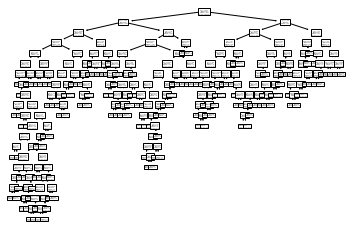

In [451]:
plot_tree(dt);

## Grid Search DT

In [505]:
grid = {'max_depth': [None, 4, 5, 6],
       'min_samples_split': [1, 2, 3],
       'min_samples_leaf': [1, 9, 10],
        
       }
grid

{'max_depth': [None, 4, 5, 6],
 'min_samples_split': [1, 2, 3],
 'min_samples_leaf': [1, 9, 10]}

In [506]:
gs = GridSearchCV(estimator=dt, scoring='precision', param_grid=grid, verbose=3, n_jobs=-3)

In [507]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-3)]: Done 180 out of 180 | elapsed:    1.4s finished


GridSearchCV(estimator=DecisionTreeClassifier(random_state=1), n_jobs=-3,
             param_grid={'max_depth': [None, 4, 5, 6],
                         'min_samples_leaf': [1, 9, 10],
                         'min_samples_split': [1, 2, 3]},
             scoring='precision', verbose=3)

In [508]:
gs.best_params_

{'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}

In [509]:
gs.best_score_

0.7185965919884872

In [510]:
final_dt = gs.best_estimator_
final_dt

DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=1)

In [520]:
cross_validate(final_dt, X_train, y_train, scoring=['precision', 'accuracy'],return_train_score=True)

{'fit_time': array([0.07073617, 0.01374316, 0.01238871, 0.01161718, 0.01230311]),
 'score_time': array([0.01384592, 0.00392866, 0.00317907, 0.00263596, 0.00292683]),
 'test_precision': array([0.84375   , 0.56603774, 0.88888889, 0.60465116, 0.68965517]),
 'train_precision': array([0.81428571, 0.82781457, 0.78205128, 0.78313253, 0.81944444]),
 'test_accuracy': array([0.9379015 , 0.90578158, 0.93576017, 0.91006424, 0.91630901]),
 'train_accuracy': array([0.93840386, 0.94429566, 0.93840386, 0.94161757, 0.94004283])}

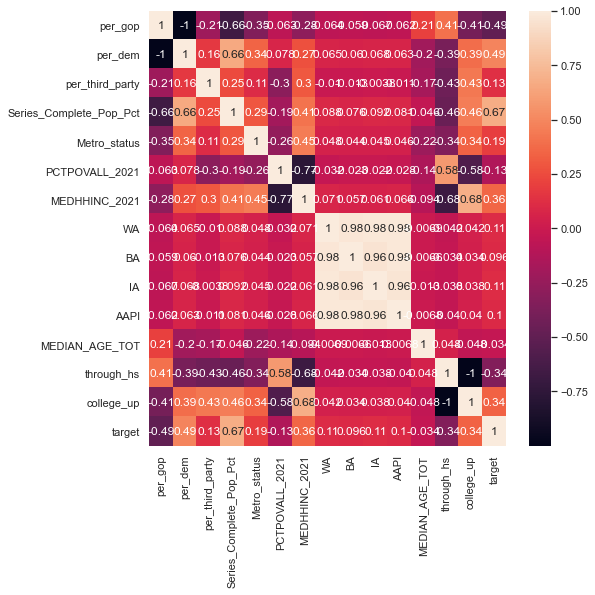

In [521]:
sns.set(rc={'figure.figsize':(8, 8)})
sns.heatmap(df.corr(), annot=True);


In [ ]:
sns.pairplot(df)

# Extras

In [ ]:
ct_data = pd.read_csv('../data/CT_data.csv', encoding="latin-1")
ct_data.head()

In [ ]:
df1 = vaccinations[(vaccinations['FIPS'] == "UNK")]
#df1["Recip_State"].value_counts(normalize=True)
df1

In [ ]:
vaccinations["Recip_County"].value_counts(normalize=True)

In [ ]:



fips_counts = vaccinations["FIPS"].value_counts().reset_index()
fips_counts.drop(index=0, inplace=True)
fips_counts["FIPS"] = fips_counts['FIPS'].astype(int)
fips_counts.sort_values(by="FIPS", inplace=True)
fips_counts
#fips_counts.sort_values(by='FIPS')
#fips_counts..head()


#fips_counts.drop("UNK", axis=0, inplace=True)
#fips_counts = fips_counts.astype(int)
#fips_counts["FIPS"].sort_values(axis=0, inplace=True)
#fips_counts.head()



In [ ]:
fips_counts = election["county_fips"].value_counts().reset_index()
fips_counts.drop(index=0, inplace=True)
fips_counts["county_fips"] = fips_counts['county_fips'].astype(int)
fips_counts.sort_values(by="county_fips", inplace=True)
fips_counts

In [ ]:
census.head(20)

# Next Steps

Need more predictors:
- Vaccine access is a big one, but couldn't find county level hospital or vaccination provider location data
- Deaths per county: [Johns Jopkins Interactive Map](https://coronavirus.jhu.edu/us-map)
- Unemployment rate: free time to get shot?
- Break down further by age? CDC has splits by age
- SVI categorical A-D